In [4]:
from pylab import *
from ipywidgets import interact
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output, HTML, display, Image

0.043000000000000003


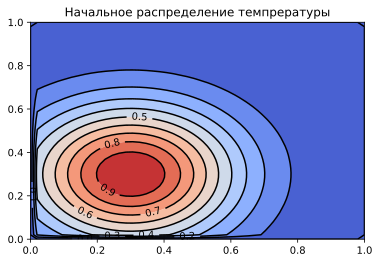

In [78]:
# Задание параметров
Lx = Ly = 1.0; Lz=0.1;
T = 0.1
Nx = 50
Ny = 50
Nz = 50
Nt = 100
dx = Lx / Nx
dy = Ly / Ny
dz = Lz / Nz
dt = T / Nt
print(dx+dy+dt+dz)
Dxx = 1/dx**2; Dyy = 1/dy**2; Dzz=1/dz**2;
X = np.linspace(0, Lx, Nx);
Y = np.linspace(0, Ly, Ny);
Z = np.linspace(0, Lz, Nz);
Tset = np.linspace(0, T, Nt);

# Инициализация начальных условий
# Sorce of heat
def f(x, y, z, t):
    if (np.abs(x)>0.7 and np.abs(y)>0.7 and np.abs(z)<0.3): 
        return 5+t
    return 0

def F(TT, dx, dy, dz):
    F_vals = np.zeros((Nt, Nx, Ny, Nz))
    for i in range (1, Nx - 1):
        for j in range(1, Ny-1):
            for k in range(1, Nz-1):
                xi = i*dx; yj = j*dy; zk = k*dz
                F_vals[:, i, j, k] = f(xi, yj, zk, Tset)

    return F_vals
F_vals = F(Tset, dx, dy, dz)
#print(F_vals)
# Initial conditions
u0 = np.zeros((Nx, Ny, Nz))
for i in range(1, Nx-1):
    for j in range(1, Ny-1):
        u0[i, j, 0:-20] = np.exp(-((X[i]-0.3)**2 + (Y[j]-0.3)**2)/0.1)
cp1=contourf(X,Y,u0[:, :, 1],10,cmap='coolwarm')
#colorbar()
plt.title("Начальное распределение темпрературы")
cp1=plt.contour(X,Y,u0[:, :, 1],10,colors='k')
plt.clabel(cp1,inline=True, fontsize=10)
show()

def matrix(a, b):
    N = len(X)
    main_diag = np.eye(N)
    help_diag = np.eye(N-1)
    main_diag = main_diag*b
    help_diag = -help_diag*a
    main_diag[1:, :-1] += help_diag
    main_diag[:-1, 1:] += help_diag
    main_diag[0, 0] = 1
    main_diag[0, 1] = -1
    main_diag[-1, -1] = -1
    main_diag[-1, -2] = 1
    return main_diag

a = 0.1



In [94]:
def solve_layer(u0, nt, f):
    u1_3 = np.zeros((Nx, Ny, Nz)) 
    # layer X
    an = a*dt/(dx**2)
    bn = 1 + 2*a*dt*Dxx
    Ax = matrix(an, bn)
    #print(A)
    Bx = np.zeros(Nx)
    for k in range(Nz):
        for j in range(Ny): 
            Bx[0] = Bx[-1] = 0
            Bx[1:-1] = u0[1:-1, j, k] + dt*f[nt, 1:-1, j, k]/3
            u1_3[:, j, k] = sp.linalg.solve(Ax, Bx)
    #layer Y
    u2_3 = np.zeros((Nx, Ny, Nz)) 
    an = a*dt/(dy**2)
    bn = 1 + 2*a*dt*Dyy
    Ay = matrix(an, bn)
    By = np.zeros(Ny)
    for k in range(Nz):
        for i in range(Nx):
            By[0] = By[-1] = 0
            By[1:-1] = u1_3[i, 1:-1, k] + dt*f[nt, i, 1:-1, k]/3
            u2_3[i, :, k] = sp.linalg.solve(Ay, By)

    #layer Z
    u = np.zeros((Nx, Ny, Nz)) 
    an = a*dt*Dzz
    bn = 1 + 2*a*dt*Dzz
    Az = matrix(an, bn)
    Bz = np.zeros(Nz)
    for j in range(Ny):
        for i in range(Nx):
            By[0] = By[-1] = 0
            By[1:-1] = u2_3[i, j, 1:-1] + dt*f[nt, i, j, 1:-1]/3
            u[i, j, :] = sp.linalg.solve(Ay, By)    
    return u

In [95]:
from IPython.display import clear_output, HTML, display, Image
def solve(u0, f):
    U = np.zeros((Nt, Nx, Ny, Nz))
    U[0] = u0
    for n in range(1, Nt):
        clear_output(wait = True)
        print(f'Progress: {round(n/(Nt), 2)*100}%') 
        U[n] = solve_layer(U[n-1], n, F_vals)
    return U

In [96]:
U = solve(u0, F_vals)

Progress: 99.0%


In [97]:
# Невязка
U_t = (U[1:, 1:-1, 1:-1, 1:-1] - U[:-1, 1:-1, 1:-1, 1:-1])/dt
U_xx = (U[:-1, 2:, 1:-1, 1:-1] - 2*U[:-1, 1:-1, 1:-1, 1:-1] + U[:-1, :-2, 1:-1, 1:-1])*Dxx
U_yy = (U[:-1, 1:-1, 2:, 1:-1] - 2*U[:-1, 1:-1, 1:-1, 1:-1] + U[:-1, 1:-1, :-2, 1:-1])*Dyy
U_zz = (U[:-1, 1:-1, 1:-1, 2:] - 2*U[:-1, 1:-1, 1:-1, 1:-1] + U[:-1, 1:-1, 1:-1, :-2])*Dzz
dU = np.abs(U_t - a*(U_xx+U_yy+U_zz) - F_vals[:-1, 1:-1, 1:-1, 1:-1])*0.01

In [98]:
# Создание интерактивного интерфейса
def displayZT(n, k, X, Y, U, dU):
    fig, (ax, ay) = plt.subplots(1, 2, figsize=(12, 7)) 
    ax.set_title("Solution")
    ay.set_title("Невязка")
    n = int(round(n/100*Nz, 0))
    if n>Nz-1:
        n = Nz-2
    k = int(round(k/100*Nt, 0))
    if k>Nt-1:
        k = Nt-2
    fig.suptitle(f"t={Tset[k]}\nz={Z[n]}")
    cp1=ax.contourf(X,Y,U[k, :, :, n],10,cmap='coolwarm')
    #plt.colorbar(cp1)
    cp1=ax.contour(X,Y,U[k, :, :, n],10,colors='k')
    plt.clabel(cp1,inline=True, fontsize=10)
    cp2=ay.contourf(X[1:-1],Y[1:-1],dU[k, :, :, n],10,cmap='hot')
    #colorbar(cp2)
    cp2=ay.contour(X[1:-1],Y[1:-1],dU[k, :, :, n],10,colors='k')
    plt.clabel(cp2,inline=True, fontsize=10)
    show()

from ipywidgets import interact
def var(n, k):
    displayZT(n, k, X, Y, U, dU)

interact(var, n=(0, 100, 1), k=(0, 100, 1))

interactive(children=(IntSlider(value=50, description='n'), IntSlider(value=50, description='k'), Output()), _…

<function __main__.var(n, k)>